In [1]:
!pip install tf2onnx onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 440 kB 4.9 MB/s 
     |████████████████████████████████| 5.2 MB 56.8 MB/s 
     |████████████████████████████████| 12.8 MB 43.1 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [2]:
!git clone https://github.com/waittim/mask-detector

Cloning into 'mask-detector'...
remote: Enumerating objects: 36671, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 36671 (delta 48), reused 110 (delta 11), pack-reused 36498
Receiving objects: 100% (36671/36671), 1.94 GiB | 34.40 MiB/s, done.
Resolving deltas: 100% (8139/8139), done.
Checking out files: 100% (19611/19611), done.


In [3]:
import os
import glob
import cv2  
import numpy as np 
import tqdm
import tensorflow as tf
from sklearn import model_selection
import matplotlib.pyplot as plt
import tf2onnx
import onnxruntime as rt
import time 

In [4]:
## converts the normalized positions  into integer positions
def unconvert(class_id, width, height, x, y, w, h):

    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)
    class_id = int(class_id)
    return (class_id, xmin, xmax, ymin, ymax)

In [5]:
dataset_path = 'mask-detector/modeling/data'
os.makedirs('mask_data', exist_ok=True)

class_path  = os.path.join(dataset_path, 'labels')
ids = list()
l=os.listdir(class_path)

check = '.DS_Store' in l
if check == True:
    l.remove('.DS_Store')

ids=[x.split('.')[0] for x in l]   

annopath = os.path.join(dataset_path, 'labels', '%s.txt')
imgpath = os.path.join(dataset_path, 'images', '%s.jpg')

for i in tqdm.tqdm(range(len(ids))):
    img_id = ids[i] 
    img = cv2.imread(imgpath % img_id)
    height, width, channels = img.shape 

    target = (annopath % img_id)
    if os.path.exists(target):
        label_norm= np.loadtxt(target).reshape(-1, 5)

        for i in range(len(label_norm)):
            labels_conv = label_norm[i]
            class_id, xmin, xmax, ymin, ymax = unconvert(labels_conv[0], width, height, labels_conv[1], labels_conv[2], labels_conv[3], labels_conv[4])

            new_img = img[ymin:ymax, xmin:xmax]
            if new_img.shape[0] == 0 or new_img is None:
                continue
            
            new_img = cv2.resize(new_img, (80,80))
            new_file_name = os.path.join('mask_data', '%s_%s_%s.jpg') % (class_id, img_id, i)

            cv2.imwrite(new_file_name, new_img)

100%|██████████| 9096/9096 [01:39<00:00, 91.43it/s] 


In [6]:
dataset_paths = glob.glob('mask_data/*')
X_list=[]
Y_list=[]

for path in dataset_paths:
  file_name = os.path.split(path)[1]
  file_name_components = file_name.split('_')
  mask = file_name_components[0]
  label = int(mask)
  image=cv2.imread(path)

  X_list.append(image)
  Y_list.append(label)

In [7]:
X = np.array(X_list,dtype="float16")
Y = np.array(Y_list,dtype='float16')

In [8]:
# split 10% of data as validation set
(trainX, testX, trainY, testY) = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [9]:
del X_list
del Y_list
del X 
del Y

In [10]:
def create_model(lr=1e-4,decay=1e-4/25, pretrained=True):
    baseModel = tf.keras.applications.MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=tf.keras.Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
    headModel = tf.keras.layers.Dense(128, activation="relu")(headModel)
    headModel = tf.keras.layers.Dropout(0.5)(headModel)
    headModel = tf.keras.layers.Dense(1, activation="sigmoid")(headModel)
    
    model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)
    
    if pretrained:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = False 
    else:
        for layer in baseModel.layers:
            layer.trainable = True 
            
    # compile model
    optimizer = tf.keras.optimizers.Adam(lr=lr, decay = decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer,metrics=["accuracy"])  
        
    return model

In [11]:
INIT_LR = 1e-4
EPOCHS = 30
BATCH_SIZE = 8

In [12]:
model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS)
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 40, 40, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 40, 40, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 40, 40, 32)   0           ['bn_Conv1[0][0]']               
                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 block_4_expand_relu (ReLU)     (None, 10, 10, 192)  0           ['block_4_expand_BN[0][0]']      
                                                                                                  
 block_4_depthwise (DepthwiseCo  (None, 10, 10, 192)  1728       ['block_4_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_4_depthwise_BN (BatchNor  (None, 10, 10, 192)  768        ['block_4_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_4_depthwise_relu (ReLU)  (None, 10, 10, 192)  0           ['block_4_depthwise_BN[0][0]']   
          

In [13]:
my_checkpointer = [
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                tf.keras.callbacks.ModelCheckpoint(filepath="mask_detect_{epoch:02d}_{val_loss:.2f}.h5", verbose=1, save_weights_only=True)
                ]

In [14]:
with tf.device('/GPU:0'):
  history = model.fit(trainX, trainY, 
                   validation_data=(testX, testY), 
                   epochs=EPOCHS, callbacks=my_checkpointer, batch_size=BATCH_SIZE)

Epoch 1/30
1749/1753 [============================>.] - ETA: 0s - loss: 0.4618 - accuracy: 0.7980
Epoch 1: saving model to mask_detect_01_0.37.h5
1753/1753 [==============================] - 32s 11ms/step - loss: 0.4618 - accuracy: 0.7980 - val_loss: 0.3709 - val_accuracy: 0.8517
Epoch 2/30
1749/1753 [============================>.] - ETA: 0s - loss: 0.3710 - accuracy: 0.8391
Epoch 2: saving model to mask_detect_02_0.36.h5
1753/1753 [==============================] - 18s 10ms/step - loss: 0.3709 - accuracy: 0.8392 - val_loss: 0.3594 - val_accuracy: 0.8372
Epoch 3/30
1752/1753 [============================>.] - ETA: 0s - loss: 0.3520 - accuracy: 0.8528
Epoch 3: saving model to mask_detect_03_0.35.h5
1753/1753 [==============================] - 18s 10ms/step - loss: 0.3520 - accuracy: 0.8528 - val_loss: 0.3497 - val_accuracy: 0.8477
Epoch 4/30
1751/1753 [============================>.] - ETA: 0s - loss: 0.3432 - accuracy: 0.8580
Epoch 4: saving model to mask_detect_04_0.33.h5
1753/1753 [

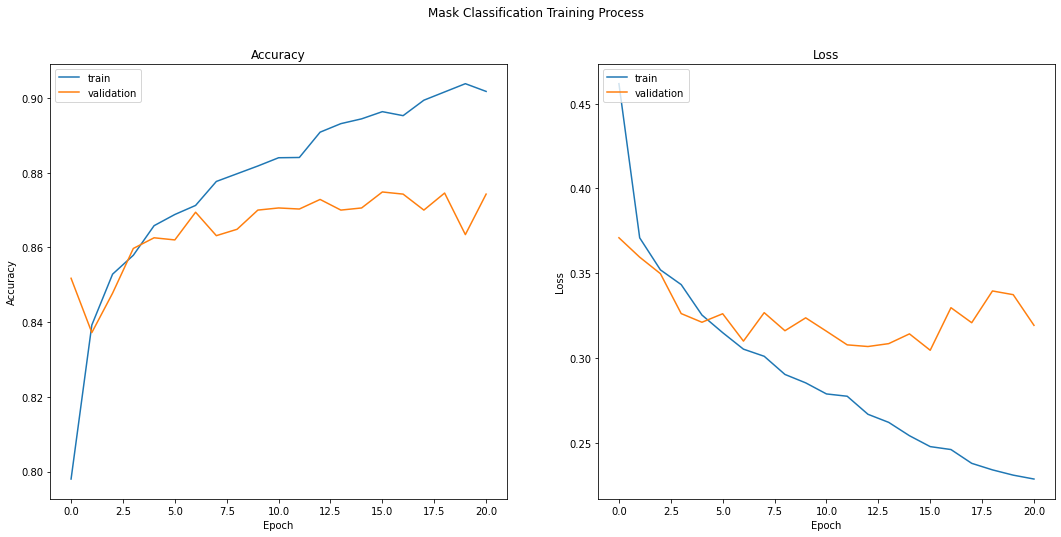

In [15]:
# Plot training process

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Mask Classification Training Process')

# accuracy
ax1.plot(history.history['accuracy'], label="train")
ax1.plot(history.history['val_accuracy'], label="validation")
ax1.set_title('Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')

# loss
ax2.plot(history.history['loss'], label="train")
ax2.plot(history.history['val_loss'], label="validation")
ax2.set_title('Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

plt.show()

In [16]:
spec = (tf.TensorSpec((None, 80, 80, 3), tf.float32, name="input"),)
output_path = model.name + ".onnx"

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [17]:
img = cv2.imread('mask_data/0_13_Interview_Interview_2_People_Visible_13_1012_0.jpg')
img = img.astype('float32')
img = np.expand_dims(img, axis=0)

providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path)

t1 = time.time()
onnx_pred = m.run(output_names, {"input": img})
t2 = time.time()
print("onnx time", t2-t1)
print("onnx pred", onnx_pred)

t3 = time.time()
pred = model.predict(img)
t4 = time.time()

print("tf time", t4-t3)
print("tf pred", pred)

onnx time 0.005482673645019531
onnx pred [array([[0.00040525]], dtype=float32)]
tf time 1.0999627113342285
tf pred [[0.00040527]]
